# Get OSM solar PV labels

## Setup

In [76]:
# Setup
import pandas as pd
import numpy as np
import datetime as dt

import glob
import os
import itertools
import collections
import re
import json
import requests
from shutil import copyfile
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import colour

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

from shapely.geometry import Polygon, Point
import geopandas as gpd
import pyproj
import folium
from folium import Rectangle
from folium import Polygon as f_Polygon
import affine

from tqdm import tqdm # Progress bar stuff cos progress bars are good
tqdm.pandas() # now can use progress_apply instead of apply

import pickle # Pickle stuff, cos pickling is good

# Styles
# pd.set_option('display.float_format', lambda x: '%.2f' % x) # pandas
# np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

import rasterio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.features import geometry_mask

from shapely.ops import transform
from functools import partial
import pyproj

In [3]:
### Utilities
def bng(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in British National Grid
    if type(df) != gpd.GeoDataFrame:
        df = gpd.GeoDataFrame(df, crs={'init':'epsg:27700'})
    elif type(df) == gpd.GeoDataFrame:
        df = df.to_crs(crs={'init':'epsg:27700'})
    return df

def wgs(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in WGS84
    if type(df) != gpd.GeoDataFrame:
        df = gpd.GeoDataFrame(df, crs={'init':'epsg:4326'})
    elif type(df) == gpd.GeoDataFrame:
        df = df.to_crs(crs={'init':'epsg:4326'})
    return df

# Mapping outlines
gb_outline = gpd.read_file('../../Data/shapefiles/Download_UK+boundaries_1183810/gb-outlines_2856975/greatbritain.shp')
towns = bng(gpd.read_file('../../Data/shapefiles/Major_Towns_and_Cities_December_2015_Boundaries_V2.geojson'))

# Raise error if CRS is not BNG
def check_bng(df):
    # Check if GeoDataFrame has CRS of BNG
    assert (df.crs == {'init': 'epsg:27700'}), 'CRS is not BNG'
    print(f'CRS of GeoDataFrame is BNG / epsg:27700')
    
def plot_uk(df):
    # Check a GeoDataFrame is in the UK somewhere. Expects dataframe in CRS BNG
    check_bng(df)
    fig, ax = plt.subplots(1, figsize=(8, 8))
    gb_outline.plot(ax=ax, color='white', linewidth=0.1, edgecolor='0.6')
    df.plot(ax=ax, linewidth=0.1, color='red', edgecolor='red')

def plot_tile_and_label(tiles, labels):
    # Expects dataframe of tiles, dataframe of labels, both in CRS BNG
    check_bng(tiles)
    check_bng(labels)
    fig, ax = plt.subplots()
    ax.axis('off')
    tiles.plot(ax=ax, color='blue')
    labels.plot(ax=ax, color='red', linewidth=0.8, edgecolor='red')

## Define OSM Queries

In [4]:
# # https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_API_by_Example

solar_query = """
    [out:json];
    area["name"="United Kingdom"]->.searchArea;
    (
    node(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
    way(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
    relation(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];    
    );
    out body;
    >;
    out skel qt;
"""

In [15]:
overpass_url = "http://overpass-api.de/api/interpreter"

# query all solar panels saved as polygon
osm_pv = requests.get(overpass_url, params={'data': solar_query})

In [26]:
df = pd.DataFrame(osm_pv.json()['elements'])

In [28]:
df.groupby('type').count()

,id,lat,lon,members,nodes,tags
type,,,,,,
node,95873,95873,95873,0,0,31763
relation,62,0,0,62,0,62
way,9687,0,0,0,9687,9408


In [34]:
nodes = df[df['type']=='node'].id.unique()

In [40]:
way_nodes = df[df['type']=='way'].nodes.values

In [42]:
unpacked_way_nodes = list(itertools.chain.from_iterable(way_nodes))

In [46]:
len(way_nodes), len(unpacked_way_nodes), len(set(unpacked_way_nodes))

(9687, 74404, 64110)

In [51]:
nodes_in_ways = list(set(nodes).intersection(set(unpacked_way_nodes)))

In [61]:
nodes_not_in_ways = list(set(nodes).difference(set(unpacked_way_nodes)))

In [62]:
len(nodes_in_ways), len(nodes_not_in_ways)

(64110, 31762)

In [63]:
df.head(1)

,id,lat,lon,members,nodes,tags,type
0,432708661,57.15,-6.21,NaN,NaN,"{'generator:method': 'photovoltaic', 'generato...",node


In [64]:
nodes_not_in_ways[0]

6357939628

In [83]:
nodes_not_in_ways = df[df['id'].isin(nodes_not_in_ways)]
nodes_not_in_ways.head(1)

,id,lat,lon,members,nodes,tags,type
0,432708661,57.15,-6.21,NaN,NaN,"{'generator:method': 'photovoltaic', 'generato...",node


In [ ]:
# # Pickle
# with open(os.path.join('data/OSM_solar_20190808.pkl'), 'wb') as f:
#     pickle.dump(osm_queried_panels, f)

Note this is polygons and points. And that multi-polygons here are turned into separate IDs... that might be troublesome.  
Try to get capacity out.  

## Try working with direct export
It works much better!

In [86]:
df = gpd.read_file('data/OSM_solar_PV_export_20190808.geojson')

In [93]:
df.groupby('source')[['id', 'generator:type', 'building', 'notional_area']].count()

,id,generator:type,building,notional_area
source,,,,
Bing,168,168,22,130
Bing Imagery,45,45,0,0
Bing;survey,49,49,0,0
DECC - RESTATS,1,0,0,0
Digital Globe Premium Imagery,33,33,0,0
Digital Globe Stadard Imagery,12,12,0,0
Digital Globe Standard,25,25,24,0
Digital Globe Standard Imagery,101,101,0,82
DigitalGlobe,1,1,1,0


In [99]:
df['osm_type'] = [x[0] for x in df['id'].str.split('/')]

In [102]:
df.groupby('osm_type')['id'].count()

osm_type
node        31763
relation       62
way          9408
Name: id, dtype: int64

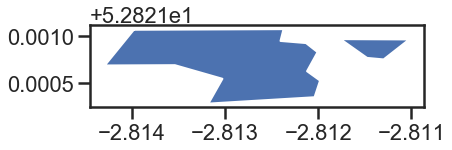

In [108]:
df[df['@relations'].notna()].plot()

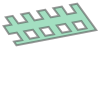

In [208]:
# Investigate shapes of relations from OSM
r = df[df['osm_type']=='relation']
i = np.random.randint(0, len(r))
# r.iloc[i].geometry
r.iloc[i].geometry

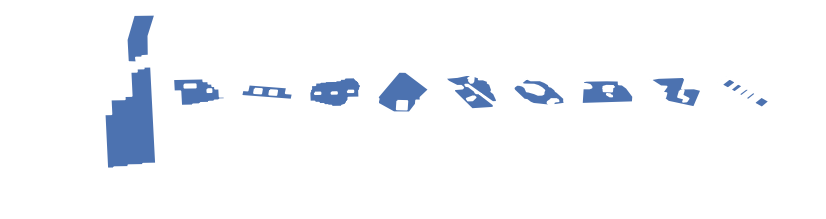

In [190]:
# Plotting geometries loses the green area vs grey area
fig, axes = plt.subplots(1, len(r[:10]), figsize=(12,12))
for i, ax in enumerate(axes):
    r.iloc[[i], :].plot(ax=ax)
    ax.axis('off')

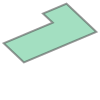

In [303]:
# Inspect Ways. Why are there green areas and grey lines? What do these represent exactly?
i = np.random.randint(0, len(df[df['osm_type'] == 'way']))
df[df['osm_type'] == 'way'].iloc[i].geometry

CRS of GeoDataFrame is BNG / epsg:27700


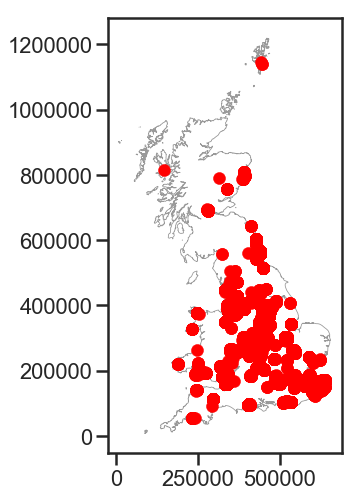

In [308]:
plot_uk(bng(df[df['osm_type'] == 'node']))

### How to generate labels from the PV points?
Ways have already been used to create labels.  
I want to add in PV points.  
Is it reasonable to just create a buffer zone and hope that will be good enough?  
PV arrays vary a lot in size, so buffer zones around central point lat/long seems like it will be inaccurate.

## Label the tiles asap, this is good enough!
With lat & lon for 16k points, this is close enough to label image chips in tiles.  
Need to only use tiles that are recent enough.  
And need to filter points to ensure they are not overlapping - but it's ok if the same image chip is picked twice, we just remove duplicates at some point.  

Assume CRS is wgs84

Data © OpenStreetMap contributors, ODbL (Terms)  
Data mining by Overpass API  


In [310]:
osm_df = df.copy()

In [311]:
osm_df.head(1)

,id,@id,generator:method,generator:output:electricity,generator:source,power,type,generator:type,generator:location,generator:orientation,source,location,building,name,tourism,amenity,note,building:levels,addr:city,addr:housenumber,addr:postcode,addr:street,shop,addr:place,addr:housename,ref:edubase,operator,fhrs:id,wheelchair,fixme,addr:country,wikidata,description,generator:place,source:addr:postcode,source:postcode,roof:levels,roof:shape,source:name,start_date,plant:method,plant:source,repd:id,frequency,leisure,sport,opening_hours,barrier,url,layer,source:1,source:2,generator:plant,level,roof:material,roof:orientation,generator:solar:modules,notional_area,notional_capacity,floating,source:geometry,generator:output:hot_water,latest_start_date,pv_module_array,height,generator:output:biogas,orientation,highway,building:material,direction,roof:colour,manufacturer,generator:solar_modules,geneator:solar:modules,@relations,earliest_start_date,generator:modules,geometry,osm_type
0,relation/8244429,relation/8244429,photovoltaic,yes,solar,generator,multipolygon,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"(POLYGON ((-2.880001 54.0362956, -2.8796828 54...",relation


In [314]:
# osm_df['geometry'] = list(zip(osm_df['lon'], osm_df['lat']))
# osm_df['geometry'] = osm_df['geometry'].apply(lambda x: Point(x))
osm_df['point'] = osm_df['geometry'].centroid

In [313]:
# osm_df = gpd.GeoDataFrame(osm_df, crs={'init': 'epsg:4326'})

In [315]:
osm_df.head(1)

,id,@id,generator:method,generator:output:electricity,generator:source,power,type,generator:type,generator:location,generator:orientation,source,location,building,name,tourism,amenity,note,building:levels,addr:city,addr:housenumber,addr:postcode,addr:street,shop,addr:place,addr:housename,ref:edubase,operator,fhrs:id,wheelchair,fixme,addr:country,wikidata,description,generator:place,source:addr:postcode,source:postcode,roof:levels,roof:shape,source:name,start_date,plant:method,plant:source,repd:id,frequency,leisure,sport,opening_hours,barrier,url,layer,source:1,source:2,generator:plant,level,roof:material,roof:orientation,generator:solar:modules,notional_area,notional_capacity,floating,source:geometry,generator:output:hot_water,latest_start_date,pv_module_array,height,generator:output:biogas,orientation,highway,building:material,direction,roof:colour,manufacturer,generator:solar_modules,geneator:solar:modules,@relations,earliest_start_date,generator:modules,geometry,osm_type,point
0,relation/8244429,relation/8244429,photovoltaic,yes,solar,generator,multipolygon,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"(POLYGON ((-2.880001 54.0362956, -2.8796828 54...",relation,POINT (-2.878820741122532 54.03901327067169)


In [317]:
osm_df = osm_df.to_crs({'init':'epsg:27700'})

In [13]:
# osm_df.to_pickle('data/osm_v1.pkl')

(-26769.15000000001, 687992.1500000001, -53559.5, 1279189.5)

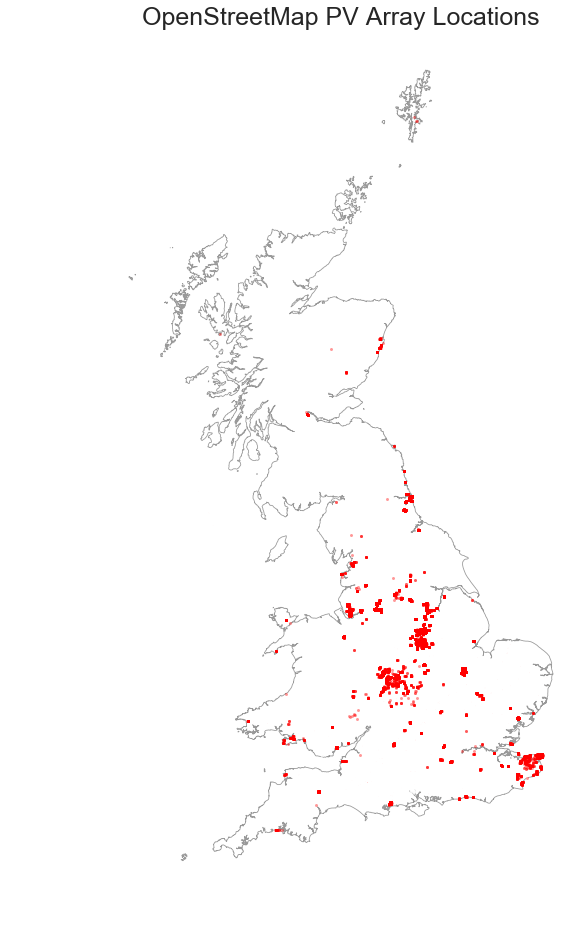

In [319]:
# plot
# Grab UK outline # crs epsg:27700
gb_outline = gpd.read_file('../../Data/shapefiles/Download_UK+boundaries_1183810/gb-outlines_2856975/greatbritain.shp')

fig, ax = plt.subplots(1, figsize=(16, 16))
gb_outline.plot(ax=ax, color='white', linewidth=0.8, edgecolor='0.6')
osm_df.plot(ax=ax, markersize=1, color='red', alpha=0.4)

ax.set_title("OpenStreetMap PV Array Locations", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')
# plt.savefig('charts/osm_pv_locations_v1.png', dpi=150)

In [15]:
# Import tagging information:
# https://wiki.openstreetmap.org/wiki/Tag:power%3Dgenerator

In [320]:
len(osm_df)

41233